# Tip Amount
    Yihnew Eshetu (yte9pc)
    Nathan England (nle4bz)
    Karyne Williams (kw7me)
 - Linear Regression Model (Benchmark)
 - Multiple Linear Regresion Model
 - Gradient-boosted Tree Regression

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseVector, Vectors
from pyspark.ml.feature import StandardScaler, VectorAssembler, ChiSqSelector, VectorIndexer, StringIndexer, OneHotEncoder
from pyspark.ml.regression import *
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import plotly_express as px

spark = (
    SparkSession 
    .builder 
    .master("local[*]") 
    .appName("Tip Amount") 
#     .config("spark.executor.memory", '15g') 
#     .config('spark.executor.cores', '1') 
#     .config('spark.executor.instances', '1') 
#     .config("spark.driver.memory",'15g') 
    .getOrCreate()
)

spark

## Data Import and Preprocessing

### Function Reads Taxi Zone

In [2]:
def taxiZone():
    taxi = spark.read.csv("/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Taxi_Zone/taxi_zone_lookup.csv", header = True)
    return taxi

### Function Reads Yellow Cab CSVs

In [3]:
def yellowCSVToDF():
    location = "/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/"

    files = sorted(glob.glob(location + '*.csv'))

    for idx,f in enumerate(files):
        df = spark.read.csv(f, header = True)
        print(f)

        if idx == 0:
            data = df
        else:
            data = data.union(df)
    return data

### Adds Taxi Zone for Pickup and Dropoff
Include extra features such as pick up/drop off borough, and service zone 

In [4]:
def yellowTaxiZone():
    # Drop Temp View if it exists
    spark.catalog.dropTempView("taxiZone")
    spark.catalog.dropTempView("yellowCab")
    
    # Create Temp View
    taxiZone().createTempView("taxiZone")
    yellowCSVToDF().createTempView("yellowCab")
    yellowCab = spark.sql("SELECT yellowCab.*,\
                     CASE WHEN PU.Borough = 'Bronx'\
                          THEN 1\
                          WHEN PU.Borough = 'Brooklyn'\
                          THEN 2\
                          WHEN PU.Borough = 'EWR'\
                          THEN 3\
                          WHEN PU.Borough = 'Manhattan'\
                          THEN 4\
                          WHEN PU.Borough = 'Queens'\
                          THEN 5\
                          WHEN PU.Borough = 'Staten Island'\
                          THEN 6\
                          ELSE 7\
                     END as PUBorough,\
                     PU.Zone as PUZone,\
                     CASE WHEN PU.service_zone = 'Airports'\
                          THEN 1\
                          WHEN PU.service_zone = 'Boro Zone'\
                          THEN 2\
                          WHEN PU.service_zone = 'EWR'\
                          THEN 3\
                          WHEN PU.service_zone = 'Yellow Zone'\
                          THEN 4\
                          ELSE 5\
                     END as PUService_Zone,\
                     CASE WHEN DO.Borough = 'Bronx'\
                          THEN 1\
                          WHEN DO.Borough = 'Brooklyn'\
                          THEN 2\
                          WHEN DO.Borough = 'EWR'\
                          THEN 3\
                          WHEN DO.Borough = 'Manhattan'\
                          THEN 4\
                          WHEN DO.Borough = 'Queens'\
                          THEN 5\
                          WHEN DO.Borough = 'Staten Island'\
                          THEN 6\
                          ELSE 7\
                     END as DOBorough,\
                     DO.Zone as DOZone,\
                     CASE WHEN DO.service_zone = 'Airports'\
                          THEN 1\
                          WHEN DO.service_zone = 'Boro Zone'\
                          THEN 2\
                          WHEN DO.service_zone = 'EWR'\
                          THEN 3\
                          WHEN DO.service_zone = 'Yellow Zone'\
                          THEN 4\
                          ELSE 5\
                     END as DOService_Zone\
                     FROM yellowCab \
                     INNER JOIN taxiZone PU\
                            ON yellowCab.PULocationID = PU.LocationID \
                     INNER JOIN taxiZone DO\
                            ON yellowCab.DOLocationID = DO.LocationID")
    return yellowCab
data = yellowTaxiZone()

/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-05.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-06.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-07.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-08.csv


### Drop duplicates

In [5]:
data = data.dropDuplicates()

### Defining Column Types

In [6]:
data = data.withColumn("VendorID", data["VendorID"].cast(StringType()))\
    .withColumn("tpep_pickup_datetime", data["tpep_pickup_datetime"].cast(TimestampType()))\
    .withColumn("tpep_dropoff_datetime", data["tpep_dropoff_datetime"].cast(TimestampType()))\
    .withColumn("passenger_count", data["passenger_count"].cast(IntegerType()))\
    .withColumn("trip_distance", data["trip_distance"].cast(FloatType()))\
    .withColumn("RatecodeID", data["RatecodeID"].cast(StringType()))\
    .withColumn("PULocationID", data["PULocationID"].cast(IntegerType()))\
    .withColumn("DOLocationID", data["DOLocationID"].cast(IntegerType()))\
    .withColumn("payment_type", data["payment_type"].cast(IntegerType()))\
    .withColumn("fare_amount", data["fare_amount"].cast(FloatType()))\
    .withColumn("extra", data["extra"].cast(FloatType()))\
    .withColumn("mta_tax", data["mta_tax"].cast(FloatType()))\
    .withColumn("tip_amount", data["tip_amount"].cast(FloatType()))\
    .withColumn("tolls_amount", data["tolls_amount"].cast(FloatType()))\
    .withColumn("improvement_surcharge", data["improvement_surcharge"].cast(FloatType()))\
    .withColumn("total_amount", data["total_amount"].cast(FloatType()))\
    .withColumn("congestion_surcharge", data["congestion_surcharge"].cast(FloatType()))

### Adding Additional Features

In [7]:
data = data.withColumn("pickup_week_day", date_format("tpep_pickup_datetime", "u").cast(IntegerType()))\
    .withColumn("pickup_hour", hour("tpep_pickup_datetime"))\
    .withColumn("dropoff_week_day", date_format("tpep_dropoff_datetime", "u").cast(IntegerType()))\
    .withColumn("dropoff_hour", hour("tpep_dropoff_datetime"))\
    .withColumn("trip_time(mins)", (col("tpep_dropoff_datetime").cast(LongType()) - col("tpep_pickup_datetime").cast(LongType()))/60)\
    .withColumn("distance/time", (col("trip_distance")/col("trip_time(mins)")))

In [8]:
data.select(["tpep_pickup_datetime", "pickup_hour", "pickup_week_day", "tpep_dropoff_datetime", 
             "dropoff_week_day", "dropoff_hour", "trip_time(mins)"]).show(3)

+--------------------+-----------+---------------+---------------------+----------------+------------+---------------+
|tpep_pickup_datetime|pickup_hour|pickup_week_day|tpep_dropoff_datetime|dropoff_week_day|dropoff_hour|trip_time(mins)|
+--------------------+-----------+---------------+---------------------+----------------+------------+---------------+
| 2019-05-01 11:11:23|         11|              3|  2019-05-01 11:40:38|               3|          11|          29.25|
| 2019-05-01 12:34:17|         12|              3|  2019-05-01 13:09:35|               3|          13|           35.3|
| 2019-05-01 16:25:43|         16|              3|  2019-05-01 17:16:46|               3|          17|          51.05|
+--------------------+-----------+---------------+---------------------+----------------+------------+---------------+
only showing top 3 rows



### Remove timestamp columns

In [9]:
data = data.drop("tpep_pickup_datetime").drop("tpep_dropoff_datetime")

### Drop NA

In [10]:
data = data.dropna()

### Print Schema

In [11]:
data.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- PUBorough: integer (nullable = false)
 |-- PUZone: string (nullable = true)
 |-- PUService_Zone: integer (nullable = false)
 |-- DOBorough: integer (nullable = false)
 |-- DOZone: string (nullable = true)
 |-- DOService_Zone: integer (nullable = false)
 |-- pickup_week_day: integer (n

### Removing Outliers

Possible Outliers
- tip_amount is null
- tip_amount is negative
- payment_type is null
- negative trip time

### Remove cash and credit card payment where total amount is less than 0

In [12]:
data = data.filter(((data.total_amount >= 0) & (data.payment_type <= 2)) | (data.payment_type > 2))

### Remove rides with trip time less than 0 mins

In [13]:
data = data.filter((col('trip_time(mins)') >= 0) & (col('trip_distance') >= 0))

## Exploratory Data Analysis

### Histogram of Tip Amount

In [14]:
tip_amount = data.filter(data.payment_type == 1)

In [15]:
tip_amount.select('tip_amount').summary().show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|          12696866|
|   mean|3.1224676651878704|
| stddev|2.9783664721843492|
|    min|               0.0|
|    25%|              1.75|
|    50%|              2.36|
|    75%|               3.5|
|    max|             537.0|
+-------+------------------+



Text(0.5, 0, 'Tip Amount')

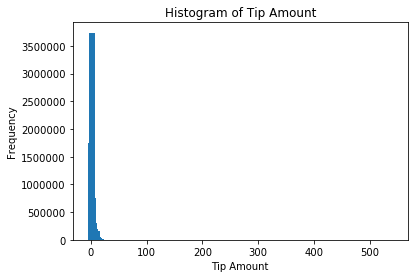

In [16]:
hists = tip_amount.select('tip_amount').rdd.flatMap(lambda row: row).histogram(500)
data_hist = {
    'bins': hists[0][:-1],
    'freq': hists[1]
    }
plt.bar(data_hist['bins'], data_hist['freq'], width=10)
plt.title('Histogram of ' + 'Tip Amount')
plt.ylabel('Frequency')
plt.xlabel('Tip Amount')

### Correlation Matrix

In [ ]:
df_corr = tip_amount.select(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'trip_time(mins)', 'distance/time'])
df_corr = df_corr.dropna()
df_corr = df_corr.select([col(c).cast("double").alias(c) for c in df_corr.columns])
assembler = VectorAssembler(inputCols=[col for col in df_corr.columns], outputCol="features")
dt = assembler.transform(df_corr)
tip_amount_corr = Correlation.corr(dt, "features").head()
corr = spark.createDataFrame(tip_amount_corr[0].toArray().tolist(), dt.columns[:-1])
corr = corr.toPandas()
corr['labels'] = dt.columns[:-1]
corr.set_index('labels', inplace = True)

In [ ]:
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=5)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".1f",
    annot_kws={'size':20}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(font_scale=5)

## We will construct a model to determine the tip amount of a taxi ride. 
What factors effect the amount of tip a passenger gives a driver? 

### Bench Mark Model - Linear

In [16]:
tip_amount = data.filter(data.payment_type == 1)
bench_mark_features = ['fare_amount']
bench_mark_data = tip_amount.select(col("tip_amount").alias("label"), *bench_mark_features)
bench_mark_data.printSchema()

root
 |-- label: float (nullable = true)
 |-- fare_amount: float (nullable = true)



In [17]:
(training, test) = bench_mark_data.randomSplit([.8, .2], seed = 10)

#### Pipeline for bench mark model

In [18]:
# Configure an ML pipeline, which consists of tree stages: vectorAssembler, standardScaler, and lr
vectorAssembler = VectorAssembler(inputCols=bench_mark_features, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(maxIter=10, regParam=.01)
stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)c

In [19]:
model = pipeline.fit(training)
prediction = model.transform(test)

#### Model Evaluation

In [20]:
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# Mean Square Error
mse = eval.evaluate(prediction, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# r2 - coefficient of determination
r2 = eval.evaluate(prediction, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

adjr2 = 1 -(((1-r2)*(test.count()-1))/(test.count()-(len(test.columns)-1)-1))
print("adjr2: %.3f" %adjr2)

MSE: 4.498
r2: 0.502
adjr2: 0.502


### Champion Models

#### Linear with Model Selection and Tuning
10 Fold Cross Validation and parameter tuning

In [24]:
additional_features = ['fare_amount', 'trip_distance', 'tolls_amount', 'congestion_surcharge']
additional_features_data = tip_amount.select(col("tip_amount").alias("label"), *additional_features)
(training_add, test_add) = additional_features_data.randomSplit([.8, .2], seed = 10)
additional_features_data.printSchema()

root
 |-- label: float (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)



Pipeline and Cross Validation

In [25]:
# Configure an ML pipeline, which consists of tree stages: vectorAssembler, standardScaler, and lr
vectorAssembler_add = VectorAssembler(inputCols=additional_features, outputCol="unscaled_features")
standardScaler_add = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr_add = LinearRegression()
stages_add = [vectorAssembler_add, standardScaler_add, lr_add]
pipeline_add = Pipeline(stages=stages_add)

# Elastic net parameter α set to 1, it is equivalent to a Lasso model. 
# if α is set to 0, the trained model reduces to a ridge regression model. 
paramGrid = ParamGridBuilder() \
    .addGrid(lr_add.regParam, [.01, 0.1, 0.3, 0.6]) \
    .addGrid(lr_add.elasticNetParam, [0, 0.3, 0.6, 1]) \
    .build()

In [26]:
crossval = CrossValidator(estimator=pipeline_add,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse"),
                          numFolds=10)  # use 10 folds

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training_add)

In [30]:
# Save Model
#cvlr_path = 'cv_lr'
#cvModel.save(cvlr_path)
#cvModel = LinearRegression.load(cvlr_path)

In [27]:
# Best model and its parameters
bestLRModel = cvModel.bestModel.stages[2]
bestLRParams = bestLRModel.extractParamMap()
bestLRParams

{Param(parent='LinearRegression_217b466c071e', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearRegression_217b466c071e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LinearRegression_217b466c071e', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35,
 Param(parent='LinearRegression_217b466c071e', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearRegression_217b466c071e', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearRegression_217b466c071e', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearRegression_217b466c071e', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError',
 Param(pa

Prediction

In [28]:
# Make predictions on test data. model is the model with combination of parameters that performed best.
prediction_tuning = cvModel.transform(test_add)

Model Evaluation

In [31]:
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# Mean Square Error
mse = eval.evaluate(prediction_tuning, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# r2 - coefficient of determination
r2 = eval.evaluate(prediction_tuning, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

adjr2 = 1 -(((1-r2)*(test_add.count()-1))/(test_add.count()-(len(test_add.columns)-1)-1))
print("adjr2: %.3f" %adjr2)

MSE: 4.175
r2: 0.537
adjr2: 0.537


#### Gradient-boosted Tree Regression with Model Selection and Tuning

In [29]:
GBT_features = ['fare_amount', 'trip_distance', 'tolls_amount', 'congestion_surcharge', 'improvement_surcharge', 'PUBorough', 'DOBorough', 'trip_time(mins)', 'distance/time', 'pickup_week_day']
tip_amountGBT = tip_amount.select(col("tip_amount").alias("label"), *GBT_features)
tip_amountGBT.cache()

DataFrame[label: float, fare_amount: float, trip_distance: float, tolls_amount: float, congestion_surcharge: float, improvement_surcharge: float, PUBorough: int, DOBorough: int, trip_time(mins): double, distance/time: double, pickup_week_day: int]

In [30]:
tip_amountGBT = tip_amountGBT.select([col(c).cast("float").alias(c) for c in tip_amountGBT.columns])
tip_amountGBT.printSchema()

root
 |-- label: float (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- PUBorough: float (nullable = false)
 |-- DOBorough: float (nullable = false)
 |-- trip_time(mins): float (nullable = true)
 |-- distance/time: float (nullable = true)
 |-- pickup_week_day: float (nullable = true)



In [31]:
# Split into training and testing
(GBTtraining, GBTtest) = tip_amountGBT.randomSplit([.8, .2], seed = 10)

Create Pipeline

In [32]:
vectorAssembler_GBT = VectorAssembler(inputCols=GBT_features, outputCol="rawFeatures")
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 7 distinct values are treated as continuous.
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=7)

Prediction

In [45]:
def gbtmodel(maxIter, maxDepth):

    gbt = GBTRegressor(featuresCol="features", maxIter = maxIter, maxDepth = maxDepth)
    pipeline = Pipeline(stages=[vectorAssembler_GBT, vectorIndexer, gbt])
    
    # Train model.  This also runs the indexer.
    gbtmodel = pipeline.fit(GBTtraining)
    prediction_tuningGBT = gbtmodel.transform(GBTtest)
    eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    # Mean Square Error
    mse = eval.evaluate(prediction_tuningGBT, {eval.metricName: "mse"})
    print("MSE: %.3f" % mse)

    # r2 - coefficient of determination
    r2 = eval.evaluate(prediction_tuningGBT, {eval.metricName: "r2"})
    print("r2: %.3f" %r2)

    adjr2 = 1 -(((1-r2)*(GBTtest.count()-1))/(GBTtest.count()-(len(GBTtest.columns)-1)-1))
    print("adjr2: %.3f" %adjr2)

Model Evaluation

In [37]:
#maxIter = 5, maxDepth = 3
gbtmodel(5, 3)

MSE: 3.973
r2: 0.545
adjr2: 0.545


In [44]:
#maxIter = 5, maxDepth = 5
gbtmodel(5, 5)

MSE: 3.767
r2: 0.569
adjr2: 0.569


In [46]:
#maxIter = 10, maxDepth = 5
gbtmodel(10, 5)

MSE: 3.713
r2: 0.575
adjr2: 0.575


In [47]:
#maxIter = 10, maxDepth = 10
gbtmodel(10, 10)

MSE: 3.649
r2: 0.582
adjr2: 0.582


In [49]:
#maxIter = 15, maxDepth = 10
gbtmodel(15, 10)

MSE: 3.644
r2: 0.583
adjr2: 0.583


**Was planning of using CrossValidator but the operation took too long.**

In [ ]:
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
vectorAssembler_GBT = VectorAssembler(inputCols=GBT_features, outputCol="rawFeatures")
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 7 distinct values are treated as continuous.
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=7)
# Takes the "features" column and learns to predict "tip_amount"
GBT = GBTRegressor(featuresCol="features")
stageGBT = [vectorAssembler_GBT, vectorIndexer, GBT]
pipelineGBT = Pipeline(stages=stageGBT)

paramGridGBT = ParamGridBuilder() \
    .addGrid(GBT.maxDepth, [3, 5, 10]) \
    .addGrid(GBT.maxIter, [5, 10]) \
    .build()

# Declare the CrossValidator, which runs model tuning
crossvalGBT = CrossValidator(estimator=pipelineGBT,
                          estimatorParamMaps=paramGridGBT,
                          evaluator=RegressionEvaluator(metricName="rmse"),
                          numFolds=3)  # use 3 folds

# Run cross-validation, and choose the best set of parameters.
cvModelGBT = crossvalGBT.fit(GBTtraining)

# Best model and its parameters
bestModelGBT = cvModelGBT.bestModel.stages[2]
bestGBTParams = bestModelGBT.extractParamMap()
bestGBTParams

# Make predictions on test data. model is the model with combination of parameters that performed best.
prediction_tuningGBT = cvModelGBT.transform(GBTtest)
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# Mean Square Error
mse = eval.evaluate(predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

adjr2 = 1 -(((1-r2)*(GBTtest.count()-1))/(GBTtest.count()-(len(GBTtest.columns)-1)-1))
print("adjr2: %.3f" %adjr2)

In [1]:
!jupyter nbconvert --to pdf tipAmount.ipynb

[NbConvertApp] Converting notebook tipAmount.ipynb to pdf
[NbConvertApp] Support files will be in tipAmount_files/
[NbConvertApp] Making directory ./tipAmount_files
[NbConvertApp] Writing 91155 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 95754 bytes to tipAmount.pdf
